In [37]:
import numpy as np
import xarray as xr
from pathlib import Path
from netCDF4 import Dataset
import argparse
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
import glob
import os
import cmocean

import cartopy.crs as ccrs
import cartopy
#import cartopy.mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from xeofs.xarray import EOF


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import scipy
from scipy import signal
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import geopandas as gpd
import cmocean


In [8]:

main_dir = Path.cwd().parent # Main directory path of project repository - all filepaths are relative to this

# File path directories
DIR_external = 'data/external/'

# DATASET FILEPATHS
# Basal melt observations from Paolo 2023
DIR_basalMeltObs = 'data/external/Paolo2023/'
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# DATA FILENAMES
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'
FILE_SORRMv21_DETRENDED = 'SORRMv21_detrended.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

# INTERIM GENERATED FILEPATHS
DIR_basalMeltObs_Interim = 'data/interim/Paolo2023/iceShelves_dedraft/iceShelfRegions/'
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/iceShelfRegions/'


In [48]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

In [9]:
ds = xr.open_dataset(main_dir / DIR_SORRMv21 / FILE_SORRMv21)
ds = ds.rename({"timeMonthly_avg_landIceFreshwaterFlux":"flux", "timeMonthly_avg_ssh":"draft"})
ds = ds.rename({"Time":"time"})
obs23_clean = xr.open_dataset(main_dir / DIR_basalMeltObs_Interim / "obs23_clean.nc")
sorrmv21_clean = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / "sorrmv21_clean.nc")
ds_meltdraft_obs = xr.open_dataset(main_dir / DIR_basalMeltObs / FILE_MeltDraftObs)

In [67]:
ds_meltdraft_obs_ts = ds_meltdraft_obs.melt.mean(["x","y"])

In [78]:
ds

<xarray.Dataset>
Dimensions:    (time: 12000, bnds: 2, x: 601, y: 601)
Coordinates:
  * time       (time) object 0001-01-16 12:20:00.036621 ... 1000-12-16 12:00:...
  * x          (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
  * y          (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
    lat        (y, x) float64 ...
    lon        (y, x) float64 ...
Dimensions without coordinates: bnds
Data variables:
    Time_bnds  (time, bnds) object ...
    flux       (time, y, x) float64 ...
    draft      (time, y, x) float64 ...
Attributes: (12/801)
    title:                                                        MPAS-Ocean ...
    source:                                                       MPAS Ocean
    source_id:                                                    a17d4b4fc0
    product:                                                      model-output
    realm:                                                        ocean
    case:                                                         20221116.CR...
    ...                                                           ...
    config_AM_conservationCheck_write_on_startup:                 NO
    config_AM_conservationCheck_write_to_logfile:                 YES
    config_AM_conservationCheck_restart_stream:                   conservatio...
    file_id:                                                      uwj3j5pmco
    NCO:                                                          netCDF Oper...
    meshName:                                                     6000.0x6000...

In [79]:
sorrmv21_clean = sorrmv21_clean.rename({"__xarray_dataarray_variable__":"flux"})

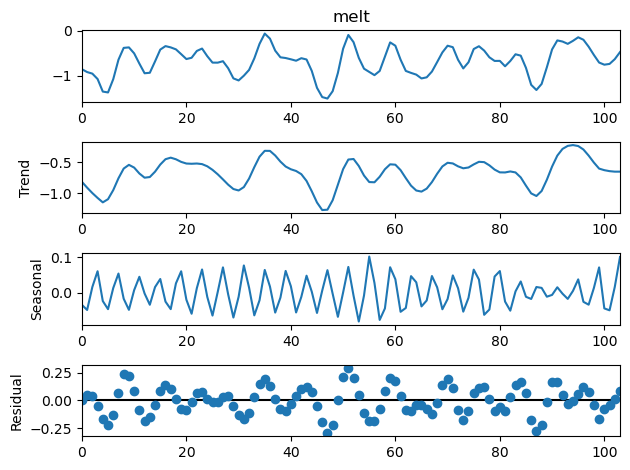

In [76]:
from statsmodels.tsa.seasonal import STL

stl = STL(ds_meltdraft_obs_ts[:], period=4)
res = stl.fit()
fig = res.plot()

In [80]:
sorrmv21_clean_ts = sorrmv21_clean.mean(["x","y"])

: 

: 

In [13]:
ds_meltdraft_obs_tmean = ds_meltdraft_obs.mean("time")

In [15]:
meanmelt = ds_meltdraft_obs_tmean.melt
meandraft = ds_meltdraft_obs_tmean.draft

In [35]:
vmindraft = np.nanquantile(meandraft[:], 0.01)
vmaxdraft = np.nanquantile(meandraft[:], 0.99)

In [49]:
def clip_data(DATA, iceShelfMask_index):
    masked_data = DATA.rio.clip(icems.loc[[iceShelfMask_index],'geometry'].apply(mapping), icems.crs, drop=False)
    return masked_data

In [52]:
meanmelt.rio.write_crs("epsg:3031",inplace=True);
meandraft.rio.write_crs("epsg:3031",inplace=True);

basin_melt = clip_data(meanmelt, 34)
basin_draft = clip_data(meandraft, 34)

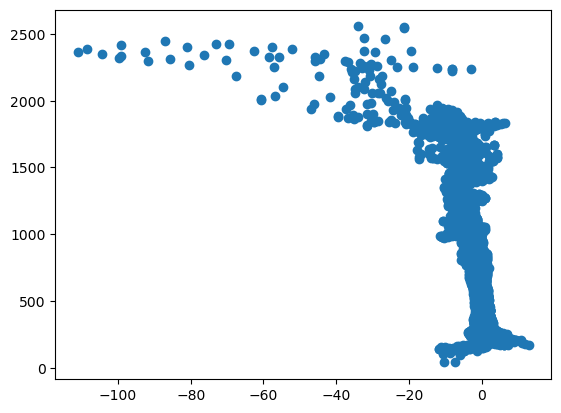

In [58]:
plt.scatter(basin_melt, basin_draft)

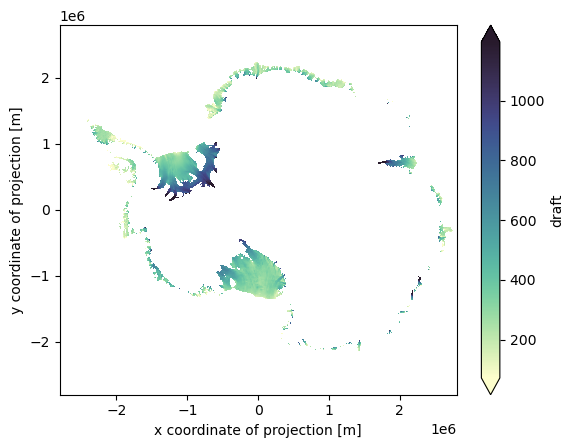

In [45]:
meandraft.plot(vmin=vmindraft, vmax=vmaxdraft, cmap=cmocean.cm.deep)

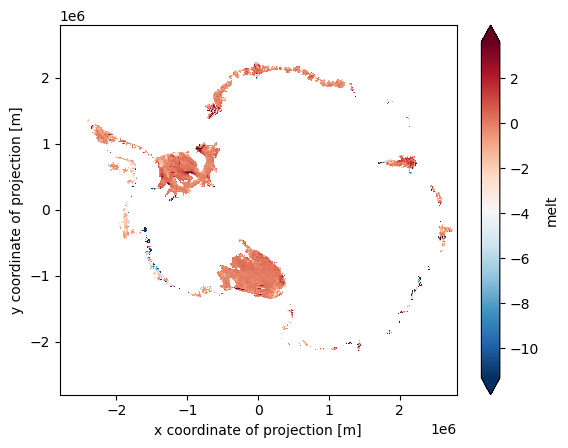

In [34]:
meanmelt.plot(vmin=vminmelt, vmax=vmaxmelt, cmap="RdBu_r")

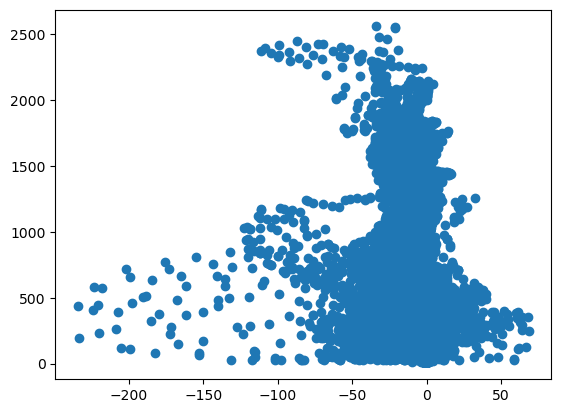

In [46]:
plt.scatter(meanmelt, meandraft)

In [30]:
vminmelt = np.nanquantile(meanmelt[:], 0.01)
vmaxmelt = np.nanquantile(meanmelt[:], 0.99)

In [ ]:
plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.scatter(ds.lon, ds.lat, c=ds.draft[100], cmap='Blues', s=10, edgecolors='k', linewidth=0.5)

In [ ]:
import hvplot
from bokeh.sampledata.autompg import autompg_clean as df
df.head()


In [ ]:
ds.draft[100].plot(cmap="Blues")
ds.flux[100].plot(ax=axs[0], cmap="Oranges")

# Add title and labels
plt.title('Bivariate Choropleth Map of Depth and Melt in Antarctica')

In [ ]:
# Create a basic map of Antarctica using cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


# Plot depth
sc = ax.scatter(ds.lon, ds.lat, c=ds.draft[100], cmap='Blues', s=10, edgecolors='k', linewidth=0.5)
plt.colorbar(sc, label='Depth')

# Overlay melt on top of depth using a scatter plot
sc = ax.scatter(ds.lon, ds.lat, c=ds.flux[100], cmap='Oranges', transform=ccrs.PlateCarree(), s=10, edgecolors='k', linewidth=0.5)
plt.colorbar(sc, label='Melt')

# Add title and labels
plt.title('Bivariate Choropleth Map of Depth and Melt in Antarctica')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
# Create a bivariate choropleth map using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Plot depth
sc_draft = ax.scatter(ds.x, ds.y, c=ds.draft[100], cmap='Blues', s=10, edgecolors='k', linewidth=0.5)
plt.colorbar(sc_draft, label='Depth')

# Overlay melt on top of depth using a scatter plot
sc_flux = ax.scatter(ds.x, ds.y, c=ds.flux[100], cmap='Oranges', s=10, edgecolors='k', linewidth=0.5)
plt.colorbar(sc_flux, label='Flux')

# Add title and labels
plt.title('Bivariate Choropleth Map of Depth and Melt')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Show the plot
plt.show()

In [ ]:
obs23_clean

In [ ]:
sorrmv21_clean = sorrmv21_clean.rename({"__xarray_dataarray_variable__":"flux", "Time":"time"})

In [ ]:
crs = ccrs.SouthPolarStereo();

In [ ]:
flux_clean = sorrmv21_clean.flux[3000:9000]

In [ ]:
sorrm_ts = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / "SORRMv21_CLEAN_TS.nc")

In [ ]:
sorrm_ts = sorrm_ts.__xarray_dataarray_variable__

In [ ]:
import statsmodels

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(sorrm_ts[:], period=13)
res = stl.fit()
fig = res.plot()

In [ ]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(sorrm_ts, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
# res_non_robust = STL(sorrm_ts, period=12, robust=False).fit()
# add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

In [ ]:
fig = plt.figure(figsize=(16, 5))
lines = plt.plot(res_robust.weights, marker="o", linestyle="none")
ax = plt.gca()

In [ ]:
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

In [ ]:
eofs.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/EOF_PCA_modes/" / "sorrmv21_eofs.nc" )
pcs.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/EOF_PCA_modes/" / "sorrmv21_pcs.nc" )
varexpl.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/EOF_PCA_modes/" / "sorrmv21_varexpl.nc" )

In [ ]:
# Normalize 
flux_clean_tmean = flux_clean.mean('time')

In [ ]:
flux_clean_tstd = flux_clean.std('time')

In [ ]:
flux_clean_demeaned = flux_clean - flux_clean_tmean


In [ ]:
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [ ]:
flux_clean_normalized.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/" / "flux_clean_6000_normalized.nc")
flux_clean_tstd.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/" / "flux_clean_6000_tstd.nc")

In [ ]:
flux_clean_normalized = xr.open_dataset(main_dir / "data/interim/SORRMv2.1.ISMF/" / "flux_clean_6000_normalized.nc")

In [ ]:
flux_clean_normalized = flux_clean_normalized.flux

In [ ]:
# Normalized variability decomposition 
norm_model = EOF(flux_clean_normalized)
norm_model.solve()
norm_eofs = norm_model.eofs()
norm_pcs = norm_model.pcs()
norm_nmodes = norm_model.n_modes
norm_varexpl = norm_model.explained_variance_ratio()
Fvn_cs = norm_varexpl.cumsum()


In [ ]:
norm_pcs_eig = norm_model.pcs(1)

In [ ]:
norm_eofs.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/EOF_PCA_modes/" / "sorrmv21_norm_eofs.nc" )
norm_pcs.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/EOF_PCA_modes/" / "sorrmv21_norm_pcs.nc" )
norm_varexpl.to_netcdf(main_dir / "data/interim/SORRMv2.1.ISMF/EOF_PCA_modes/" / "sorrmv21_norm_varexpl.nc" )

In [ ]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 4 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(12,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2])
axbig = fig.add_subplot(gs[0,:])
ax0 = [fig.add_subplot(gs[i,0],projection=crs) for i in range(1,nmodes_plot)]
ax1 = [fig.add_subplot(gs[i,1]) for i in range(1,nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    norm_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a0.set_title('EOF Mode {}'.format(i+1))
    #a1.set_ylim(-3,3)
    a1.plot(norm_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')
    a1.set_title('PC Mode {}'.format(i+1))
    a1.tick_params(labelbottom=False, left=False, grid_alpha=0.3)

a1.set_xlabel('Time (months)');

m = 500
xvar = np.linspace(1,m,m)
axbig.plot(xvar,Fvn_cs[:m]*100, 'k*--', lw=0.5,markersize=1.75,
         label='Actual Data: {:.2f}\%'.format(norm_varexpl[:m].sum().values*100))
axbig.set_ylabel('Cumulative variance captured (\%)')
axbig.set_xlabel('Mode Number')
axbig.set_title('Cumulative variance captured by first {} modes'.format(m));
axbig.tick_params(labelbottom=True, left=False, grid_alpha=0.3)
axbig.legend();

fig.tight_layout()

In [ ]:
sorrmv21_clean = xr.open_dataset(main_dir / DIR_SORRMv21_Interim / "sorrmv21_clean.nc", chunks={"Time":300})

In [ ]:
if 'time' in ds.dims:
    tdim = 'time'
elif 'Time' in ds.dims:
    tdim = 'Time'

In [ ]:
obs23_ts = obs23_clean.sum(["x","y"])
# sorrmv21_ts = sorrmv21_clean.sum(["x","y"])

In [ ]:
dsmonth = ds.groupby("Time.month")

In [ ]:
dsmonth

In [ ]:


# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = sorrmv21_clean.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [ ]:
sorrmv21_ts = sorrmv21_clean.__xarray_dataarray_variable__.sum(["x","y"]).compute()

In [ ]:
plt.figure(figsize=(25,8))
sorrmv21_ts.plot()

In [ ]:
plt.figure(figsize=(15,8))
plt.psd(obs23_ts.melt);
plt.psd(sorrmv21_ts);

In [ ]:
plt.psd(obs23_ts.melt);
plt.psd(sorrm_ts[3000:9000]);

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(sorrm_ts[3000:9000])

In [ ]:
DIR_SORRMv21 = Path("data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/iceShelfRegions/")
main_dir / DIR_SORRMv21.parent / FILE_SORRMv21_DETRENDED

In [ ]:
sorrm_clean_ts = xr.open_dataset(main_dir / DIR_SORRMv21 / "SORRMv21_CLEAN_TS.nc")
sorrm_ts = sorrm_clean_ts.__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(12,8))
#ds.__xarray_dataarray_variable__.plot()
plt.psd(ds.__xarray_dataarray_variable__[8000:10000]);
plt.psd(ds.__xarray_dataarray_variable__[3000:9000]);
# plt.psd(obs23_ts.melt);
plt.psd(ds.__xarray_dataarray_variable__);
# plt.psd(sorrmv21_ts);

In [ ]:
# STANDARDIZE

obs23_ts_mean = obs23_ts.mean()
obs23_ts_std = obs23_ts.std()
obs23_ts_norm = (obs23_ts - obs23_ts_mean)/obs23_ts_std

sorrm_ts_mean = sorrm_ts.mean()
sorrm_ts_std = sorrm_ts.std()
sorrm_ts_norm = (sorrm_ts - sorrm_ts_mean)/sorrm_ts_std


In [ ]:
obs23_ts_norm.melt

In [ ]:
plt.psd(obs23_ts_norm.melt);
plt.psd(sorrm_ts_norm[3000:9000]);

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(obs23_ts_norm.melt)
plt.plot(sorrm_ts_norm[:250], '--')

In [ ]:
main_dir / DIR_SORRMv21.parent

In [ ]:
ctrlRegional = xr.open_dataset(ctrl+regionalStats)
exp01Regional = xr.open_dataset(exp01+regionalStats)

#ctrlglobal = xr.open_dataset(ctrl+globalStats)
exp01global = xr.open_dataset(exp01+globalStats)

In [ ]:
ds = xr.open_dataset(dir1)
ds2 = xr.open_dataset(dir2)
ds3 = xr.open_dataset(dir3)
ds.deltat[:50].plot(label='obs23MALI (50 of 325 timesteps)')
ds2.deltat.plot(label='origMALI')
tmpds.deltat.plot(label='obs23MALI (Modified timestep)')
#ds3.deltat[:50].plot(label='obs23-1101-MALI')
plt.title('ismip6/hist04 runs')
plt.legend()

In [ ]:
#ds.surfaceSpeedMax[:50].plot(label='obs23MALI (100 of 325 timesteps)')
ds2.surfaceSpeedMax.plot(label='origMALI')
tmpds.surfaceSpeedMax.plot(label='obs23MALI (Modified timestep)')
#ds3.deltat[:50].plot(label='obs23-1101-MALI')
plt.title('ismip6/hist04 runs')
plt.legend()

In [ ]:
MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_basalMeltObs / FILE_MeltDraftObs, chunks={'x':729, 'y':729})

In [ ]:
MELTDRAFT_OBS.rio.write_crs("epsg:3031",inplace=True);


In [ ]:
h = MELTDRAFT_OBS.draft
if 'time' in h.dims:
    tdim = 'time'
elif 'Time' in h.dims:
    tdim = 'Time'

h_mean = h.mean(tdim)

IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

In [ ]:
mlt = MELTDRAFT_OBS.melt.rio.clip(icems.loc[[34],'geometry'].apply(mapping),icems.crs,drop=False)
mlt_mean = mlt.mean(tdim)
# Dedraft: Linear Regression with SSH over chosen basin
print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
mlt_rgrs = xr_linregress(h, mlt_mean, dim=tdim) # h = independent variable

In [ ]:
mlt_prd = mlt_rgrs.slope*h_mean + mlt_rgrs.intercept

In [ ]:
icems.name.values

In [ ]:
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'
FILE_SORRMv21_DETRENDED_TS = 'SORRMv21_detrended_ts.nc'

ds = xr.open_dataset(main_dir / DIR_SORRMv21 / FILE_SORRMv21_DETRENDED_TS)


In [ ]:
ds["flux_sum"] = ds.__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(25,8))
ds.__xarray_dataarray_variable__.plot()

In [ ]:
ds.__xarray_dataarray_variable__.rename("flux_xy_sum")

In [ ]:
ds